# Modelling Intrusion Detection: Analysis of a Feature Selection Mechanism

## Method Description

### Step 1: Data preprocessing:
All features are made numerical using one-Hot-encoding. The features are scaled to avoid features with large values that may weigh too much in the results.

### Step 2: Feature Selection:
Eliminate redundant and irrelevant data by selecting a subset of relevant features that fully represents the given problem.
Univariate feature selection with ANOVA F-test. This analyzes each feature individually to detemine the strength of the relationship between the feature and labels. Using SecondPercentile method (sklearn.feature_selection) to select features based on percentile of the highest scores. 
When this subset is found: Recursive Feature Elimination (RFE) is applied.

### Step 4: Build the model:
Decision tree model is built.

### Step 5: Prediction & Evaluation (validation):
Using the test data to make predictions of the model.
Multiple scores are considered such as:accuracy score, recall, f-measure, confusion matrix.
perform a 10-fold cross-validation.

In [1]:
import pandas as pd
import numpy as np
import sys
import sklearn
print(pd.__version__)
print(np.__version__)
print(sys.version)
print(sklearn.__version__)

1.0.1
1.18.1
3.7.6 (default, Jan  8 2020, 13:42:34) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
0.22.2.post1


## Load the Dataset

In [2]:
# attach the column names to the dataset
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

# KDDTrain+_2.csv & KDDTest+_2.csv are the datafiles without the last column about the difficulty score
# these have already been removed.
df = pd.read_csv("KDDTrain+_2.csv", header=None, names = col_names)
df_test = pd.read_csv("KDDTest+_2.csv", header=None, names = col_names)

# shape, this gives the dimensions of the dataset
print('Dimensions of the Training set:',df.shape)
print('Dimensions of the Test set:',df_test.shape)

Dimensions of the Training set: (125973, 42)
Dimensions of the Test set: (22544, 42)


## Sample view of the training dataset

In [3]:
# colums that are categorical and not binary yet: protocol_type (column 2), service (column 3), flag (column 4).
# explore categorical features
print('Training set:')
for col_name in df.columns:
    if df[col_name].dtypes == 'object' :
        unique_cat = len(df[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

#see how distributed the feature service is, it is evenly distributed and therefore we need to make dummies for all.
print()
print('Distribution of categories in service:')
print(df['service'].value_counts().sort_values(ascending=False).head())

Training set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 70 categories
Feature 'flag' has 11 categories
Feature 'label' has 23 categories

Distribution of categories in service:
http        40338
private     21853
domain_u     9043
smtp         7313
ftp_data     6860
Name: service, dtype: int64


In [4]:
# Test set
print('Test set:')
for col_name in df_test.columns:
    if df_test[col_name].dtypes == 'object' :
        unique_cat = len(df_test[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

Test set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 64 categories
Feature 'flag' has 11 categories
Feature 'label' has 38 categories


### Conclusion: Need to make dummies for all categories as the distribution is fairly even. In total: 3+70+11=84 dummies.
### Comparing the results shows that the Test set has fewer categories (6), these need to be added as empty columns.

# LabelEncoder

### Insert categorical features into a 2D numpy array

In [5]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
categorical_columns=['protocol_type', 'service', 'flag']
# insert code to get a list of categorical columns into a variable, categorical_columns
categorical_columns=['protocol_type', 'service', 'flag'] 
 # Get the categorical values into a 2D numpy array
df_categorical_values = df[categorical_columns]
testdf_categorical_values = df_test[categorical_columns]
df_categorical_values.head()

,protocol_type,service,flag
0,tcp,ftp_data,SF
1,udp,other,SF
2,tcp,private,S0
3,tcp,http,SF
4,tcp,http,SF


### Make column names for dummies

In [6]:
# protocol type
unique_protocol=sorted(df.protocol_type.unique())
string1 = 'Protocol_type_'
unique_protocol2=[string1 + x for x in unique_protocol]
# service
unique_service=sorted(df.service.unique())
string2 = 'service_'
unique_service2=[string2 + x for x in unique_service]
# flag
unique_flag=sorted(df.flag.unique())
string3 = 'flag_'
unique_flag2=[string3 + x for x in unique_flag]
# put together
dumcols=unique_protocol2 + unique_service2 + unique_flag2
print(dumcols)

#do same for test set
unique_service_test=sorted(df_test.service.unique())
unique_service2_test=[string2 + x for x in unique_service_test]
testdumcols=unique_protocol2 + unique_service2_test + unique_flag2

['Protocol_type_icmp', 'Protocol_type_tcp', 'Protocol_type_udp', 'service_IRC', 'service_X11', 'service_Z39_50', 'service_aol', 'service_auth', 'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf', 'service_daytime', 'service_discard', 'service_domain', 'service_domain_u', 'service_echo', 'service_eco_i', 'service_ecr_i', 'service_efs', 'service_exec', 'service_finger', 'service_ftp', 'service_ftp_data', 'service_gopher', 'service_harvest', 'service_hostnames', 'service_http', 'service_http_2784', 'service_http_443', 'service_http_8001', 'service_imap4', 'service_iso_tsap', 'service_klogin', 'service_kshell', 'service_ldap', 'service_link', 'service_login', 'service_mtp', 'service_name', 'service_netbios_dgm', 'service_netbios_ns', 'service_netbios_ssn', 'service_netstat', 'service_nnsp', 'service_nntp', 'service_ntp_u', 'service_other', 'service_pm_dump', 'service_pop_2', 'service_pop_3', 'service_printer', 'service_private', 'service_red_i', 'service_remote_job', 'serv

## Transform categorical features into numbers using LabelEncoder()

In [7]:
df_categorical_values_enc=df_categorical_values.apply(LabelEncoder().fit_transform)
print(df_categorical_values_enc.head())
# test set
testdf_categorical_values_enc=testdf_categorical_values.apply(LabelEncoder().fit_transform)

protocol_type  service  flag
0              1       20     9
1              2       44     9
2              1       49     5
3              1       24     9
4              1       24     9


# One-Hot-Encoding

In [8]:
enc = OneHotEncoder()
df_categorical_values_encenc = enc.fit_transform(df_categorical_values_enc)
df_cat_data = pd.DataFrame(df_categorical_values_encenc.toarray(),columns=dumcols)
# test set
testdf_categorical_values_encenc = enc.fit_transform(testdf_categorical_values_enc)
testdf_cat_data = pd.DataFrame(testdf_categorical_values_encenc.toarray(),columns=testdumcols)

df_cat_data.head()

,Protocol_type_icmp,Protocol_type_tcp,Protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Add 6 missing categories from train set to test set

In [9]:
trainservice=df['service'].tolist()
testservice= df_test['service'].tolist()
difference=list(set(trainservice) - set(testservice))
string = 'service_'
difference=[string + x for x in difference]
difference

['service_http_2784',
 'service_urh_i',
 'service_harvest',
 'service_http_8001',
 'service_red_i',
 'service_aol']

In [10]:
for col in difference:
    testdf_cat_data[col] = 0

testdf_cat_data.shape

(22544, 84)

## Join encoded categorical dataframe with the non-categorical dataframe

In [11]:
newdf=df.join(df_cat_data)
newdf.drop('flag', axis=1, inplace=True)
newdf.drop('protocol_type', axis=1, inplace=True)
newdf.drop('service', axis=1, inplace=True)
# test data
newdf_test=df_test.join(testdf_cat_data)
newdf_test.drop('flag', axis=1, inplace=True)
newdf_test.drop('protocol_type', axis=1, inplace=True)
newdf_test.drop('service', axis=1, inplace=True)
print(newdf.shape)
print(newdf_test.shape)

(125973, 123)
(22544, 123)


# Split Dataset into 4 datasets for every attack category
## Rename every attack label: 0=normal, 1=DoS, 2=Probe, 3=R2L and 4=U2R.
## Replace labels column with new labels column
## Make new datasets


In [12]:
# take label column
labeldf=newdf['label']
labeldf_test=newdf_test['label']
# change the label column
newlabeldf=labeldf.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})
newlabeldf_test=labeldf_test.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})
# put the new label column back
newdf['label'] = newlabeldf
newdf_test['label'] = newlabeldf_test
print(newdf['label'].head())

0    0
1    0
2    1
3    0
4    0
Name: label, dtype: int64


In [13]:
newdf

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,491,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,146,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0,232,8153,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,199,420,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
125969,8,105,145,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
125970,0,2231,384,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
125971,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [14]:
newlabeldf

0         0
1         0
2         1
3         0
4         0
         ..
125968    1
125969    0
125970    0
125971    1
125972    0
Name: label, Length: 125973, dtype: int64

In [15]:
to_drop_DoS = [2,3,4]
to_drop_Probe = [1,3,4]
to_drop_R2L = [1,2,4]
to_drop_U2R = [1,2,3]
DoS_df=newdf[~newdf['label'].isin(to_drop_DoS)];
Probe_df=newdf[~newdf['label'].isin(to_drop_Probe)];
R2L_df=newdf[~newdf['label'].isin(to_drop_R2L)];
U2R_df=newdf[~newdf['label'].isin(to_drop_U2R)];

#test
DoS_df_test=newdf_test[~newdf_test['label'].isin(to_drop_DoS)];
Probe_df_test=newdf_test[~newdf_test['label'].isin(to_drop_Probe)];
R2L_df_test=newdf_test[~newdf_test['label'].isin(to_drop_R2L)];
U2R_df_test=newdf_test[~newdf_test['label'].isin(to_drop_U2R)];
print('Train:')
print('Dimensions of DoS:' ,DoS_df.shape)
print('Dimensions of Probe:' ,Probe_df.shape)
print('Dimensions of R2L:' ,R2L_df.shape)
print('Dimensions of U2R:' ,U2R_df.shape)
print('Test:')
print('Dimensions of DoS:' ,DoS_df_test.shape)
print('Dimensions of Probe:' ,Probe_df_test.shape)
print('Dimensions of R2L:' ,R2L_df_test.shape)
print('Dimensions of U2R:' ,U2R_df_test.shape)

Train:
Dimensions of DoS: (113270, 123)
Dimensions of Probe: (78999, 123)
Dimensions of R2L: (68338, 123)
Dimensions of U2R: (67395, 123)
Test:
Dimensions of DoS: (17171, 123)
Dimensions of Probe: (12132, 123)
Dimensions of R2L: (12596, 123)
Dimensions of U2R: (9778, 123)


# Step 2: Feature Scaling:

In [16]:
# Split dataframes into X & Y
# assign X as a dataframe of feautures and Y as a series of outcome variables
X_DoS = DoS_df.drop('label',1)
Y_DoS = DoS_df.label
X_Probe = Probe_df.drop('label',1)
Y_Probe = Probe_df.label
X_R2L = R2L_df.drop('label',1)
Y_R2L = R2L_df.label
X_U2R = U2R_df.drop('label',1)
Y_U2R = U2R_df.label
# test set
X_DoS_test = DoS_df_test.drop('label',1)
Y_DoS_test = DoS_df_test.label
X_Probe_test = Probe_df_test.drop('label',1)
Y_Probe_test = Probe_df_test.label
X_R2L_test = R2L_df_test.drop('label',1)
Y_R2L_test = R2L_df_test.label
X_U2R_test = U2R_df_test.drop('label',1)
Y_U2R_test = U2R_df_test.label

### Save a list of feature names for later use (it is the same for every attack category). Column names are dropped at this stage.

In [17]:
colNames=list(X_DoS)
colNames_test=list(X_DoS_test)

## Use StandardScaler() to scale the dataframes

In [18]:
from sklearn import preprocessing
scaler1 = preprocessing.StandardScaler().fit(X_DoS)
X_DoS=scaler1.transform(X_DoS) 
scaler2 = preprocessing.StandardScaler().fit(X_Probe)
X_Probe=scaler2.transform(X_Probe) 
scaler3 = preprocessing.StandardScaler().fit(X_R2L)
X_R2L=scaler3.transform(X_R2L) 
scaler4 = preprocessing.StandardScaler().fit(X_U2R)
X_U2R=scaler4.transform(X_U2R) 
# test data
scaler5 = preprocessing.StandardScaler().fit(X_DoS_test)
X_DoS_test=scaler5.transform(X_DoS_test) 
scaler6 = preprocessing.StandardScaler().fit(X_Probe_test)
X_Probe_test=scaler6.transform(X_Probe_test) 
scaler7 = preprocessing.StandardScaler().fit(X_R2L_test)
X_R2L_test=scaler7.transform(X_R2L_test) 
scaler8 = preprocessing.StandardScaler().fit(X_U2R_test)
X_U2R_test=scaler8.transform(X_U2R_test) 

In [19]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [20]:
Y_DoS

0         0
1         0
2         1
3         0
4         0
         ..
125968    1
125969    0
125970    0
125971    1
125972    0
Name: label, Length: 113270, dtype: int64

In [21]:
def to_image(array0):
    array0 = np.array(array0)
    array0 = np.column_stack((array0, np.zeros((array0.shape[0], 22))))
    return array0.reshape((array0.shape[0],12,12,1))

train_list = [X_DoS,X_Probe,X_R2L,X_U2R]

def to_label(array0):
    array0 = np.array(array0)
    return array0.reshape((array0.shape[0],1))

train_images, train_labels, test_images, test_labels = to_image(X_DoS), to_label(Y_DoS), to_image(X_DoS_test), to_label(Y_DoS_test)

In [22]:
train_images

array([[[[-0.09931945],
         [-0.02416949],
         [-0.05230875],
         ...,
         [-0.01224919],
         [-0.03479891],
         [-0.02563565]],

        [[-0.01300717],
         [-0.02635973],
         [-0.01816318],
         ...,
         [-0.67746807],
         [-0.67486954],
         [-0.31275949]],

        [[-0.31513492],
         [ 0.78410408],
         [-0.36120902],
         ...,
         [-0.28319232],
         [-0.6790732 ],
         [-0.66681444]],

        ...,

        [[-0.07748466],
         [-0.07334048],
         [-0.07713797],
         ...,
         [-0.05670128],
         [-0.03310482],
         [-0.01993587]],

        [[ 0.81604613],
         [-0.00420205],
         [ 0.        ],
         ...,
         [ 0.        ],
         [ 0.        ],
         [ 0.        ]],

        [[ 0.        ],
         [ 0.        ],
         [ 0.        ],
         ...,
         [ 0.        ],
         [ 0.        ],
         [ 0.        ]]],


       [[[-0.09931945],


In [23]:
model = models.Sequential()
model.add(layers.Conv2D(32, (2, 2), activation='relu', input_shape=(12, 12, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 11, 11, 32)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 64)          8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                6

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Train on 113270 samples, validate on 17171 samples
Epoch 1/10
113270/113270 [==============================] - 11s 98us/sample - loss: 0.0414 - accuracy: 0.9897 - val_loss: 0.5928 - val_accuracy: 0.8908
Epoch 2/10
113270/113270 [==============================] - 10s 87us/sample - loss: 0.0096 - accuracy: 0.9976 - val_loss: 0.7763 - val_accuracy: 0.8545
Epoch 3/10
113270/113270 [==============================] - 10s 87us/sample - loss: 0.0060 - accuracy: 0.9982 - val_loss: 0.7841 - val_accuracy: 0.8803
Epoch 4/10
113270/113270 [==============================] - 10s 89us/sample - loss: 0.0050 - accuracy: 0.9986 - val_loss: 0.6159 - val_accuracy: 0.8973
Epoch 5/10
113270/113270 [==============================] - 10s 89us/sample - loss: 0.0039 - accuracy: 0.9989 - val_loss: 0.9793 - val_accuracy: 0.8672
Epoch 6/10
113270/113270 [==============================] - 10s 90us/sample - loss: 0.0035 - accuracy: 0.9990 - val_loss: 0.8504 - val_accuracy: 0.8822
Epoch 7/10
113270/113270 [===========

17171/17171 - 1s - loss: 0.8851 - accuracy: 0.8666
0.8665774


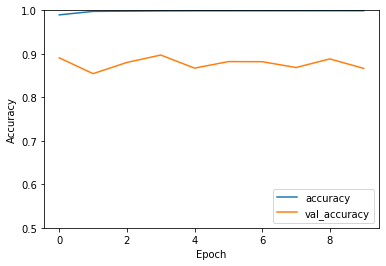

In [26]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print(test_acc)

In [27]:
print(test_acc)

0.8665774
